## Setup

In [1]:
# Check versions of Keras and Tensorflow
#!pip install -U keras # Don't upgrade Keras for 24SP because hw1 was still Keras 2
!pip list | egrep 'keras|tensorflow\s|jax\s'

jax                                      0.4.23
jupyter-server-mathjax                   0.2.6
keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6
tensorflow                               2.15.0


In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

2024-02-29 05:21:01.166275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 05:21:01.166395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 05:21:01.303201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
Keras version: 2.15.0, backend: tensorflow
GPUs: 1


In [3]:
data_dir = Path('/kaggle/input/handwritten-letter-classification-24sp')
!ls {data_dir}

sample_submission.csv  test  test.csv  train  train.csv


In [4]:
train_df = pd.read_csv(data_dir / 'train.csv').sort_values('filename')
train_df['label_as_int'] = ['abc'.index(x) for x in train_df['label']]
test_df = pd.read_csv(data_dir / 'test.csv').sort_values('filename')
train_df.head()

,id,filename,label,label_as_int
0,51,051.png,b,1
1,52,052.png,b,1
2,56,056.png,c,2
3,70,070.jpg,a,0
4,85,085.png,b,1


In [5]:
# REPLACE THIS with the path to your Homework 1 model weights:
# Upload it as either a Dataset or a Model, then find the .weights.h5 file on the right side and click the Copy File Path link.
WEIGHTS_FILENAME = '/kaggle/input/test-weights/hw1.weights.h5'

# Make sure that this config matches the weights you saved (Really only the model_preset should matter.)
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 20
    batch_size = 8
    image_size = (256, 256)
    model_preset = "densenet201_imagenet"
    use_zero_init = True

In [6]:
# Reproducibility: Set a seed so that the results are the same every time this is run.
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(config.seed)

### Load the competition data

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [7]:
# Define which classes we want to use, in what order.
class_names = ['a', 'b', 'c']

# Create training and validation datasets
def get_dataset(path, labels_as_ints):
    return keras.utils.image_dataset_from_directory(
        path,
        labels=list(labels_as_ints) if labels_as_ints is not None else None,
        label_mode='int' if labels_as_ints is not None else None,
        batch_size=config.batch_size,
        image_size=config.image_size,
        crop_to_aspect_ratio=True,
        shuffle=False
    )

train_dataset = get_dataset(data_dir / 'train', train_df['label_as_int'])
test_dataset = get_dataset(data_dir / 'test', None)

Found 111 files belonging to 3 classes.
Found 2128 files belonging to 1 classes.


Let's show some example images.

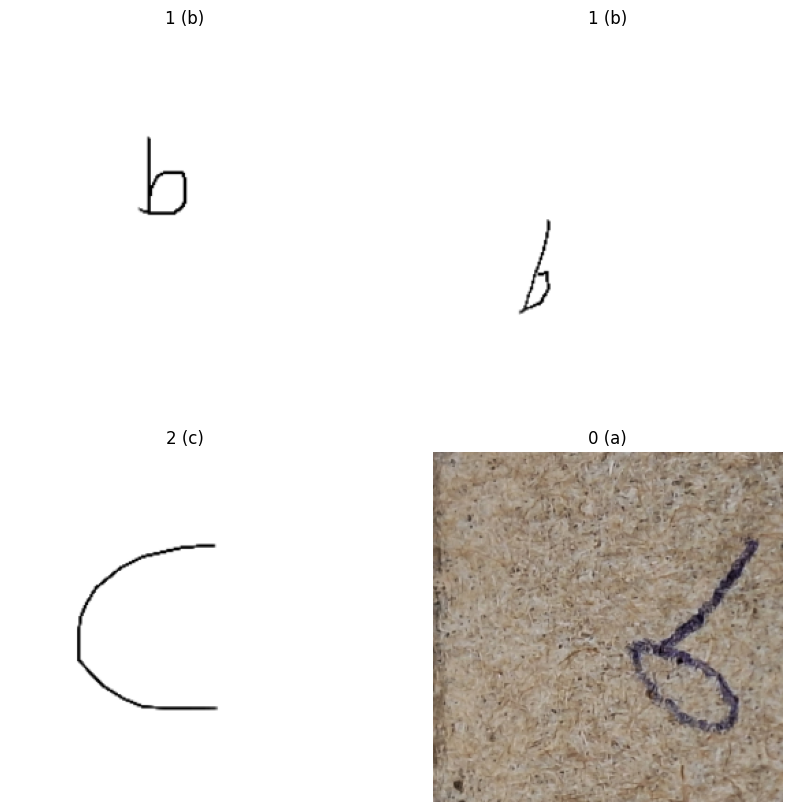

In [8]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')

## Load the model

This code uses the weights file from above.

In [9]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# model.load_weights(WEIGHTS_FILENAME)

Attaching 'config.json' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "image_classifier"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, None, None, 3)]   0         Y          
                                                                            
 dense_net_backbone (DenseN  (None, None, None, 1920   1832198   Y          
 etBackbone)                 )                         4                    
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1920)              0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 3)                 5763      Y          
                                                                            
Total params: 18327747 (69.91 MB)
Trainable params

In [10]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://students.cs.calvin.edu/~ajm94/CS-375/HW01/letters.zip",
    extract=True,
)

data_path = Path(path_to_downloaded_file).parent / 'letters'
!ls {data_path}

# Define which classes we want to use, in what order.
class_names = ['A', 'B', 'C']

# Create training and validation datasets
temp_train_dataset, temp_val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.01,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

305750/305750 [==============================] - 1s 2us/step
A  B  C  README.txt
Found 100 files belonging to 3 classes.
Using 99 files for training.
Using 1 files for validation.


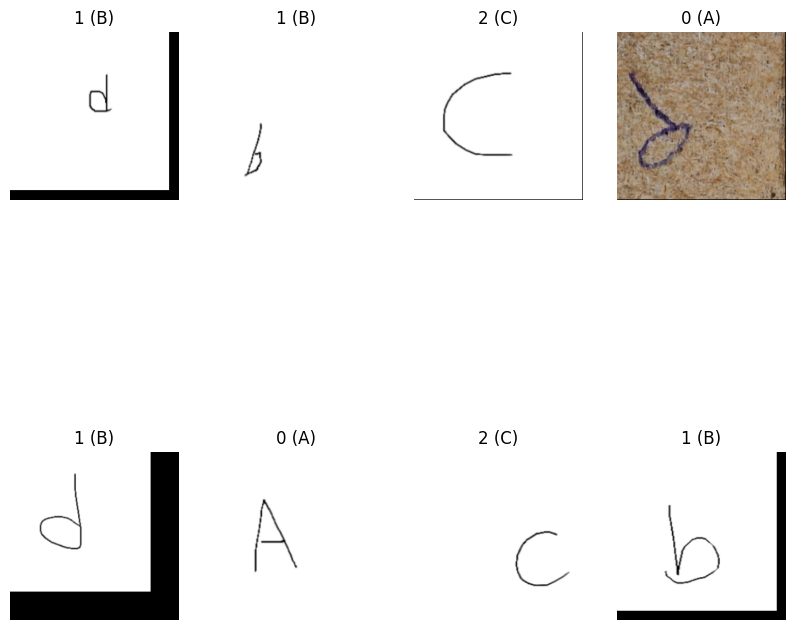

In [11]:
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]

crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size= config.image_size,
    crop_area_factor=(0.9, 1.0),
    aspect_ratio_factor=(0.9, 1.1),
)
augmenters += [crop_and_resize]

rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=2,
    value_range=(0, 255),
    magnitude=0.1,
    magnitude_stddev=0.15,
    rate=10/11,
)
# augmenters += [rand_augment]

rgb_shift = keras_cv.layers.RandomChannelShift(value_range=(0, 255),
    factor=0.5)
# augmenters += [rgb_shift]

random_saturation = keras_cv.layers.RandomSaturation(factor=(0,1))
augmenters += [random_saturation]

jittered_resize = keras_cv.layers.JitteredResize(
    target_size=config.image_size,
    scale_factor=(0.8, 1.25),
    bounding_box_format="xywh",
)
augmenters += [jittered_resize]

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augment = create_augmenter_fn(augmenters)



train_dataset_with_aug = train_dataset.map(
  lambda inputs, labels: (augment(inputs), labels),
  num_parallel_calls=tf.data.AUTOTUNE)

[[example_images, example_labels]] = train_dataset_with_aug.take(1)
fig, axs = plt.subplots(2, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')

In [12]:
model.fit(train_dataset_with_aug,
    validation_data=temp_train_dataset,
    epochs=config.epochs)

Epoch 1/20


I0000 00:00:1709184178.502534      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 138s 1s/step - loss: 0.9384 - accuracy: 0.4775 - val_loss: 1.1050 - val_accuracy: 0.3939
Epoch 2/20
14/14 [==============================] - 3s 208ms/step - loss: 0.4374 - accuracy: 0.8378 - val_loss: 0.9593 - val_accuracy: 0.5758
Epoch 3/20
14/14 [==============================] - 3s 217ms/step - loss: 0.2502 - accuracy: 0.9099 - val_loss: 0.3753 - val_accuracy: 0.8485
Epoch 4/20
14/14 [==============================] - 3s 207ms/step - loss: 0.1928 - accuracy: 0.9459 - val_loss: 0.4276 - val_accuracy: 0.8384
Epoch 5/20
14/14 [==============================] - 3s 208ms/step - loss: 0.2632 - accuracy: 0.8919 - val_loss: 1.0267 - val_accuracy: 0.5657
Epoch 6/20
14/14 [==============================] - 3s 205ms/step - loss: 0.2980 - accuracy: 0.9099 - val_loss: 0.2297 - val_accuracy: 0.9091
Epoch 7/20
14/14 [==============================] - 3s 209ms/step - loss: 0.1365 - accuracy: 0.9820 - val_loss: 0.3024 - val_accuracy: 0.9091
Epoch 8/20
14/14 [

In [13]:
# This is the code you'd run in the Homework 1 notebook to save the weights file.
# It'll then appear in the "Output" section on the right.
#model.save_weights("hw1.weights.h5")

## Analysis of classifier errors

Use the `train` set as a validation set for diagnosing the classifier's errors.

14/14 [==============================] - 4s 50ms/step


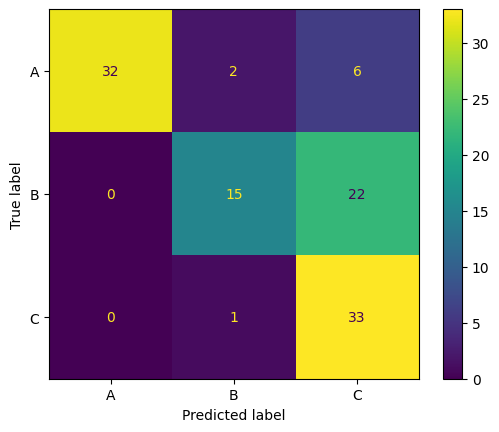

In [14]:
val_predicted_probs = model.predict(train_dataset)
val_predictions = np.argmax(val_predicted_probs, axis=1)
val_labels = [int(label) for img, label in train_dataset.unbatch()]

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(val_labels, val_predictions, display_labels=class_names)

### Make predictions on test set

This code creates a `submission.csv` file with the labels that `model` gives for the test set.

In [15]:
test_predicted_probs = model.predict(test_dataset)
test_predictions = np.argmax(test_predicted_probs, axis=1)
test_df['label'] = [class_names[x].lower() for x in test_predictions]
test_df[['id', 'label']].to_csv('submission.csv', index=False)

266/266 [==============================] - 14s 40ms/step
